### ***Importación de librerias***

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import feature
from tqdm import tqdm
from skimage.io import imread_collection
from sklearn.cluster import KMeans
import pywt
from scipy.stats import gennorm
import os

C:\Users\matea\AppData\Local\Temp\ipykernel_12576\3754441510.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### ***Funciones auxiliares***

In [2]:
def convert2image(data_list, size):
    img_data = np.reshape(np.array(data_list), (size,size))
    return  img_data

def save_new_csv(path, data):
    if os.path.exists(path): 
        pass
    else:
        data.to_csv(path, index=False)

### ***Lectura de datos de entrenamiento y prueba***

In [3]:
train = pd.read_csv('dataset2/CSV_V2/clothes_V2.csv')
x_train = imread_collection('dataset2/images_train_V2/*.jpg')

print(len(x_train))

x_test = imread_collection('dataset2/images_test_V2/*.jpg')

print(len(x_test))

800
199


### ***Verificación de datos leidos***

(-0.5, 223.5, 223.5, -0.5)

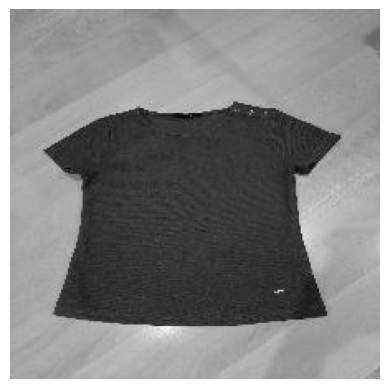

In [4]:
plt.imshow(x_train[0], cmap='gray')
plt.axis('off')

### ***Caracterización de imágenes***

#### ***Haralick***

(-0.5, 255.5, 255.5, -0.5)

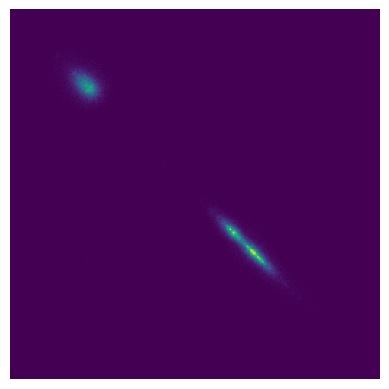

In [5]:
glcm_sample = feature.graycomatrix(convert2image(x_train[0], 224), [2], [np.pi/2], levels=256, symmetric=True, normed=True).ravel()

plt.imshow(convert2image(glcm_sample,256))
plt.axis('off')

##### En la imagen anterior se pueden observar las carcaterísticas de textura 

In [6]:
def haralick_descriptor(images, size, distance, angles, moments):

    def GLCM(image, size, distance, angles):
        glcm = feature.graycomatrix(convert2image(image,size), distance, angles, levels=256, symmetric=True, normed=True)
        return glcm

    feature_moments = []
    Haralick_features = np.array([])

    for i in tqdm(range(0,len(images))):
        for moment in moments:
            haralick_moments = feature.graycoprops(GLCM(images[i], size, distance, angles), prop= moment).ravel().tolist()
            feature_moments += haralick_moments

        if i == 0:
            Haralick_features = np.array(feature_moments)
        else:
            Haralick_features = np.vstack((Haralick_features, np.array(feature_moments)))
        feature_moments = []   
    
    return Haralick_features

#### ***Se hallan los descriptores de Haralick para cada imagen***

In [7]:
Haralick_features_train = haralick_descriptor(x_train, 224, [1,2,3], [0, np.pi/2],['contrast', 'dissimilarity', 'homogeneity'])

Haralick_features_train.shape

100%|██████████| 800/800 [01:16<00:00, 10.49it/s]


(800, 18)

In [8]:
Haralick_features_test = haralick_descriptor(x_test, 224, [1,2,3], [0, np.pi/2],['contrast', 'dissimilarity', 'homogeneity'])

Haralick_features_test.shape

100%|██████████| 199/199 [00:19<00:00, 10.18it/s]


(199, 18)

#### ***Se almacenan los resultados en un archivo CSV***

In [9]:
pd_Haralick_features_train= pd.DataFrame(Haralick_features_train)
pd_Haralick_features_test= pd.DataFrame(Haralick_features_test)

save_new_csv('dataset2/CSV_V2/Haralick_Descriptor_clothes_Train.csv', pd_Haralick_features_train)
save_new_csv('dataset2/CSV_V2/Haralick_Descriptor_clothes_Test.csv', pd_Haralick_features_test)

#### ***HOG***

(-0.5, 223.5, 223.5, -0.5)

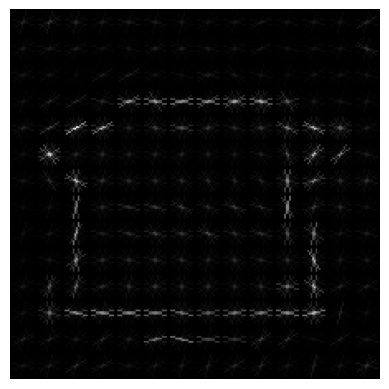

In [10]:
fd_sample, hog_image_sample = feature.hog(convert2image(x_train[0],224), orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=None)

plt.imshow(hog_image_sample, cmap='gray')
plt.axis('off')

##### En la imagen anterior se puede observar puntos de orientación la imagen que expresan la forma de la prenda

In [11]:
def hog_descriptor(data,size, ppp):
    fd,_ = feature.hog(convert2image(data,size), 
                        orientations=8, 
                        pixels_per_cell=(ppp, ppp),
                        cells_per_block=(1, 1), 
                        visualize=True, 
                        channel_axis=None)
    return fd

In [12]:
def hog_descriptor(images, size, ppp):

    def HOG_characteristic(image,size, ppp):
        fd,_ = feature.hog(convert2image(image, size), 
                            orientations=8, 
                            pixels_per_cell=(ppp, ppp),
                            cells_per_block=(1, 1), 
                            visualize=True, 
                            channel_axis=None)
        return fd
    
    HOG = np.array([])

    for i in tqdm(range(0,len(images))):
        if i == 0:
            HOG = np.array([HOG_characteristic(images[i], size, ppp)])
        else:
            HOG = np.vstack((HOG, np.array([HOG_characteristic(x_train[i], size, ppp)])))
    
    return HOG


#### ***Se hallan los descriptores de HOG para cada imagen***

In [13]:
HOG_train = hog_descriptor(x_train, 224, 16)
HOG_train.shape

100%|██████████| 800/800 [01:07<00:00, 11.85it/s]


(800, 1568)

In [14]:
HOG_test = hog_descriptor(x_test, 224, 16)
HOG_test.shape

100%|██████████| 199/199 [00:15<00:00, 12.53it/s]


(199, 1568)

#### ***Se almacenan los resultados en un archivo CSV***

In [15]:
pdHOG_train = pd.DataFrame(HOG_train)
pdHOG_test = pd.DataFrame(HOG_test)

save_new_csv('dataset2/CSV_V2/HOG_Descriptor_clothes_Train.csv', pdHOG_train)
save_new_csv('dataset2/CSV_V2/HOG_Descriptor_clothes_Test.csv', pdHOG_test)

#### ***LBP***

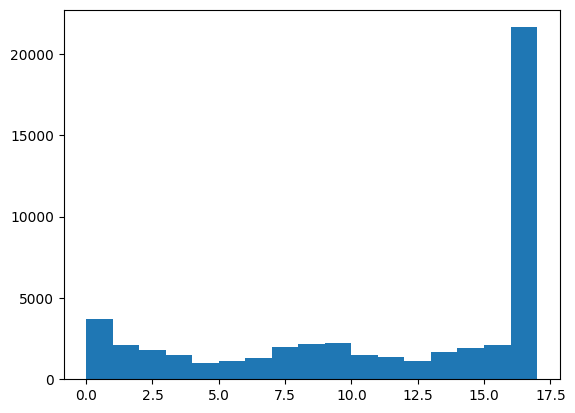

In [16]:
R = 2
P = 8*R
LBP_sample = feature.local_binary_pattern(x_train[0], P, R, method='uniform').ravel()
hist_LBP = plt.hist(LBP_sample, bins=P+1)

##### En la imagen anterior se puede observar las texturas de la imagen y cual es la de mayor incidencia

In [17]:
def LBP_descriptor(images, R):
    R = 2
    P = 8*R

    LBP_hist = np.array([])

    for i in tqdm(range(0,len(images))):

        LBP,_ = np.histogram(feature.local_binary_pattern(images[i], P, R, method='uniform').ravel(), bins=P+1)

        if i == 0:
            LBP_hist = np.array([LBP])
        else:
            LBP_hist = np.vstack((LBP_hist, LBP))       

    return LBP_hist

#### ***Se hallan los descriptores de LBP para cada imagen***

In [18]:
LBP_train = LBP_descriptor(x_train, 2)
LBP_train.shape

100%|██████████| 800/800 [00:28<00:00, 28.07it/s]


(800, 17)

In [19]:
LBP_test = LBP_descriptor(x_test, 2)
LBP_test.shape

100%|██████████| 199/199 [00:06<00:00, 28.82it/s]


(199, 17)

#### ***Se almacenan los resultados en un archivo CSV***

In [20]:
pdLBP_train = pd.DataFrame(LBP_train)
pdLBP_test = pd.DataFrame(LBP_test)

save_new_csv('dataset2/CSV_V2/LBP_Descriptor_clothes_Train.csv', pdLBP_train)
save_new_csv('dataset2/CSV_V2/LBP_Descriptor_clothes_Test.csv', pdLBP_test)

#### ***SIFT***

In [4]:
def SIFT_Descriptor(image, num_keyPoints):

    SIFT_detector = feature.SIFT(upsampling=1, 
                                n_octaves=8,
                                n_scales=3, 
                                sigma_min=1.6, 
                                c_dog=0.013333333333333334, 
                                c_edge=10, 
                                n_bins=8, 
                                lambda_ori=1.5, 
                                c_max=0.8, 
                                lambda_descr=6, 
                                n_hist=4, 
                                n_ori=8)

    SIFT_detector.detect_and_extract(image)

    shape_KeyPoints = SIFT_detector.keypoints.shape[0]

    if shape_KeyPoints < num_keyPoints:
        num_keyPoints = shape_KeyPoints

    idx = np.random.choice(np.arange(shape_KeyPoints), size = num_keyPoints, replace = False)

    return SIFT_detector.descriptors[idx,:]

In [5]:
SIFT_descript = SIFT_Descriptor(x_train[0], 30)
SIFT_descript.shape

(25, 128)

In [6]:
def extract_SIFT_Features(images, num_keypoints):
    features  = []
    for image in tqdm(images):
        descriptor = SIFT_Descriptor(image, num_keypoints).tolist()
        features += descriptor
    return np.array(features)


In [38]:
# from multiprocessing import Pool
# import multiprocessing_SIFT
# import workers

# if __name__ ==  '__main__': 
#     pool = Pool(processes = 4)
#     #SIFT2 = pool.map(multiprocessing_SIFT.extract_SIFT_Features, x_train[0])
#     SIFT2 = pool.map(multiprocessing_SIFT.SIFT_Descriptor, x_train[0])
#     pool.close()
#     pool.join()
#     print(SIFT2)


In [39]:
SIFT_train = extract_SIFT_Features(x_train, 30)
SIFT_test = extract_SIFT_Features(x_test, 30)

100%|██████████| 199/199 [00:17<00:00, 11.25it/s]


In [40]:
grouping = KMeans(n_clusters = 20)
grouping.fit(SIFT_train)

c:\Users\matea\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=20)

[ 4  0  0  0  1  1  0  0  0  0  0  0  1  0  0  0  0  3 11  4]


(array([16.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

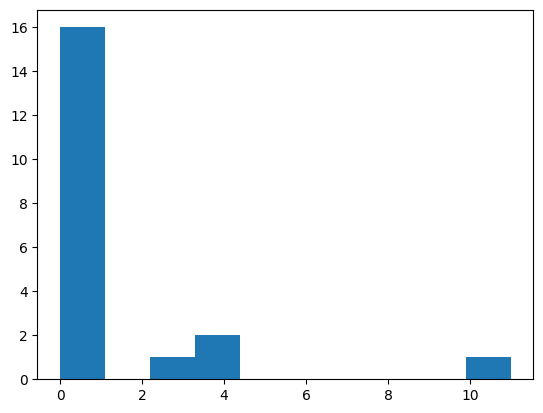

In [41]:
SIFT_group = grouping.predict(SIFT_descript)
SIFT_group_vector,_ = np.histogram(SIFT_group, bins = 20)
print(SIFT_group_vector)
plt.hist(SIFT_group_vector)

## Agregar for para todas las imagenes calcular el SIFT y calcular el histograma  (SIFT_group = grouping.predict(SIFT_descript))

##### En la imagen anterior se puede observar los grupos que poseen carcateristicas similares

In [42]:
def groupVector_SIFT(images, SIFT_images, clusters):
        
    features_group = np.array([])

    grouping = KMeans(n_clusters = clusters)
    grouping.fit(SIFT_images)

    
    for i in tqdm(range(0,len(images))):

        SIFT_descript = SIFT_Descriptor(images[i], 30)

        SIFT_group = grouping.predict(SIFT_descript)
        SIFT_group_vector,_ = np.histogram(SIFT_group, bins = 20)

        if i == 0:
            features_group = np.array([SIFT_group_vector])
        else:
            features_group = np.vstack((features_group, SIFT_group_vector))       

    return features_group
    

#### ***Se hallan los descriptores de SIFT para cada imagen***

In [43]:
goupSIFTTrain = groupVector_SIFT(x_train, SIFT_train, 20)
goupSIFTTest = groupVector_SIFT(x_test, SIFT_test, 20)

c:\Users\matea\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 800/800 [01:26<00:00,  9.26it/s]
c:\Users\matea\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 199/199 [00:18<00:00, 10.97it/s]


#### ***Se almacenan los resultados en un archivo CSV***

In [44]:
pdSIFT_train = pd.DataFrame(goupSIFTTrain)
pdSIFT_test = pd.DataFrame(goupSIFTTest)

save_new_csv('dataset2/CSV_V2/SIFT_Descriptor_clothes_Train.csv', pdSIFT_train)
save_new_csv('dataset2/CSV_V2/SIFT_Descriptor_clothes_Test.csv', pdSIFT_test)

#### ***WAVELET***

(array([1.1000e+01, 2.1000e+01, 1.7000e+01, 9.5000e+01, 1.2194e+04,
        1.4400e+02, 2.3000e+01, 1.4000e+01, 1.7000e+01, 8.0000e+00]),
 array([-146.  , -113.75,  -81.5 ,  -49.25,  -17.  ,   15.25,   47.5 ,
          79.75,  112.  ,  144.25,  176.5 ]),
 <BarContainer object of 10 artists>)

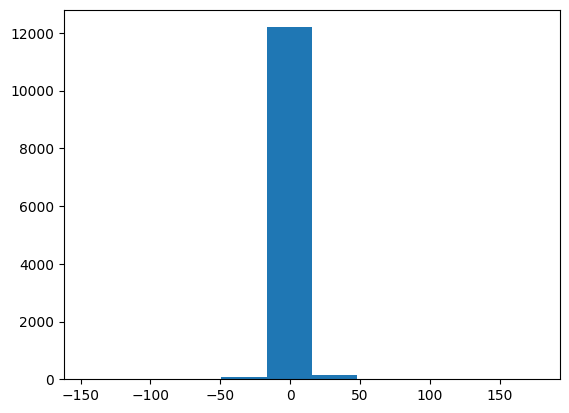

In [45]:
wavelets = pywt.wavedec2(x_train[0], 'haar', mode = 'symmetric', level = 3)
plt.hist(wavelets[3][0].ravel())

##### En la imagen anterior se puede observar la forma de onda WAVELET de Haar como expresa características de la imagen

(array([  2.,   1.,   1.,   2.,   2.,   3., 109., 862.,  12.,   6.]),
 array([-475.77878281, -408.57127895, -341.36377509, -274.15627123,
        -206.94876737, -139.7412635 ,  -72.53375964,   -5.32625578,
          61.88124808,  129.08875194,  196.2962558 ]),
 <BarContainer object of 10 artists>)

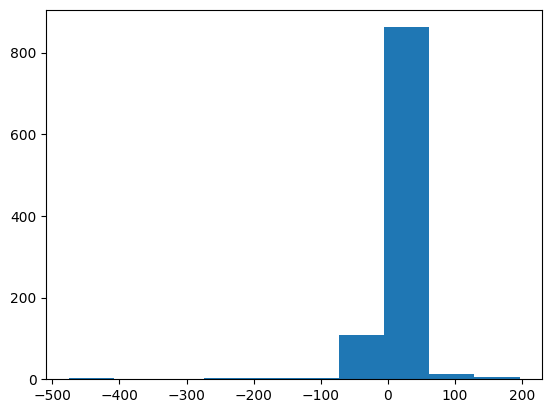

In [46]:
beta, mu, sigma = gennorm.fit(wavelets[3][0].ravel())
random_numbers = gennorm.rvs(beta, mu, sigma, size = 1000)
plt.hist(random_numbers)

In [47]:
def WAVELET(images, levels = 3):

    WAVELET_features = np.array([])

    for i in tqdm(range(0,len(images))):
        wavelets = pywt.wavedec2(images[i], 'haar', mode = 'symmetric', level = levels)

        features = gennorm.fit(wavelets[0].ravel())
        
        for coef in wavelets[1:]:
            for detail in coef:
                features += gennorm.fit(detail.ravel())     

        if i == 0:
            WAVELET_features = np.array([features])
        else:
            WAVELET_features = np.vstack((WAVELET_features, features))       


    return WAVELET_features

#### ***Se hallan los descriptores de WAVELET para cada imagen***

In [48]:
WAVELET_descriptor_Train = WAVELET(x_train, 3)
WAVELET_descriptor_Train.shape

100%|██████████| 800/800 [21:19<00:00,  1.60s/it]


(800, 30)

In [49]:
WAVELET_descriptor_Test = WAVELET(x_test, 3)
WAVELET_descriptor_Test.shape

100%|██████████| 199/199 [05:29<00:00,  1.65s/it]


(199, 30)

#### ***Se almacenan los resultados en un archivo CSV***

In [50]:
pdWAVELET_train = pd.DataFrame(WAVELET_descriptor_Train)
pdWAVELET_test = pd.DataFrame(WAVELET_descriptor_Test)

save_new_csv('dataset2/CSV_V2/WAVELET_Descriptor_clothes_Train.csv', pdWAVELET_train)
save_new_csv('dataset2/CSV_V2/WAVELET_Descriptor_clothes_Test.csv', pdWAVELET_test)